# Import libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter

import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [2]:
df=pd.read_csv('Airplane_Crashes_and_Fatalities_Since_1908.csv')
df.head(5)

Date   Time                            Location  \
0  09/17/1908  17:18                 Fort Myer, Virginia   
1  07/12/1912  06:30             AtlantiCity, New Jersey   
2  08/06/1913    NaN  Victoria, British Columbia, Canada   
3  09/09/1913  18:30                  Over the North Sea   
4  10/17/1913  10:30          Near Johannisthal, Germany   

                 Operator Flight #          Route                    Type  \
0    Military - U.S. Army      NaN  Demonstration        Wright Flyer III   
1    Military - U.S. Navy      NaN    Test flight               Dirigible   
2                 Private        -            NaN        Curtiss seaplane   
3  Military - German Navy      NaN            NaN  Zeppelin L-1 (airship)   
4  Military - German Navy      NaN            NaN  Zeppelin L-2 (airship)   

  Registration cn/In  Aboard  Fatalities  Ground  \
0          NaN     1     2.0         1.0     0.0   
1          NaN   NaN     5.0         5.0     0.0   
2          NaN   NaN     1.0         1.0     0.0   
3          NaN   NaN    20.0        14.0     0.0   
4          NaN   NaN    30.0        30.0     0.0   

                                             Summary  
0  During a demonstration flight, a U.S. Army fly...  
1  First U.S. dirigible Akron exploded just offsh...  
2  The first fatal airplane accident in Canada oc...  
3  The airship flew into a thunderstorm and encou...  
4  Hydrogen gas which was being vented was sucked...

In [3]:
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Year'].head(5)

0    1908
1    1912
2    1913
3    1913
4    1913
Name: Year, dtype: int64

# Data Cleaning

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5268 entries, 0 to 5267
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          5268 non-null   object 
 1   Time          3049 non-null   object 
 2   Location      5248 non-null   object 
 3   Operator      5250 non-null   object 
 4   Flight #      1069 non-null   object 
 5   Route         3562 non-null   object 
 6   Type          5241 non-null   object 
 7   Registration  4933 non-null   object 
 8   cn/In         4040 non-null   object 
 9   Aboard        5246 non-null   float64
 10  Fatalities    5256 non-null   float64
 11  Ground        5246 non-null   float64
 12  Summary       4878 non-null   object 
 13  Year          5268 non-null   int64  
dtypes: float64(3), int64(1), object(10)
memory usage: 576.3+ KB


In [5]:
df.columns

Index(['Date', 'Time', 'Location', 'Operator', 'Flight #', 'Route', 'Type',
       'Registration', 'cn/In', 'Aboard', 'Fatalities', 'Ground', 'Summary',
       'Year'],
      dtype='object')

In [6]:
df.isna().sum()

Date               0
Time            2219
Location          20
Operator          18
Flight #        4199
Route           1706
Type              27
Registration     335
cn/In           1228
Aboard            22
Fatalities        12
Ground            22
Summary          390
Year               0
dtype: int64

In [7]:
data = df.dropna()
data.head(3)

Date   Time               Location  \
208  01/19/1930  18:23  Oceanside, California   
236  03/31/1931  10:45         Bazaar, Kansas   
334  08/31/1934  23:42     Amazonia, Missouri   

                              Operator Flight #  \
208                    Maddux Airlines        7   
236  Trans Continental and Western Air      599   
334                Rapid Air Transport        6   

                                    Route                   Type Registration  \
208   Aqua Caliente, Mexico - Los Angeles  Ford 5-AT-C Tri Motor       NC9689   
236  Kansas City - Wichita -  Los Angeles   Fokker F10A Trimotor       NC-999   
334                    Omaha - St. Joseph      Stinson  SM-6000B      NC10809   

        cn/In  Aboard  Fatalities  Ground  \
208  5-AT-046    16.0        16.0     0.0   
236      1063     8.0         8.0     0.0   
334      5004     5.0         5.0     0.0   

                                               Summary  Year  
208  While en route to Los Angeles, the pilot, flyi...  1930  
236  Shortly after taking off from Kansas City, one...  1931  
334  The plane crashed about 11 miles from St. Jose...  1934

In [8]:
print('number of rows  before discarding duplicates = %d' % (data.shape[0]))
airplane= data.drop_duplicates()
print("number of rows after discarding duplicates = %d" % (data.shape[0]))

number of rows  before discarding duplicates = 944
number of rows after discarding duplicates = 944


In [9]:
airplane.isnull().values.any()

False

# EDA

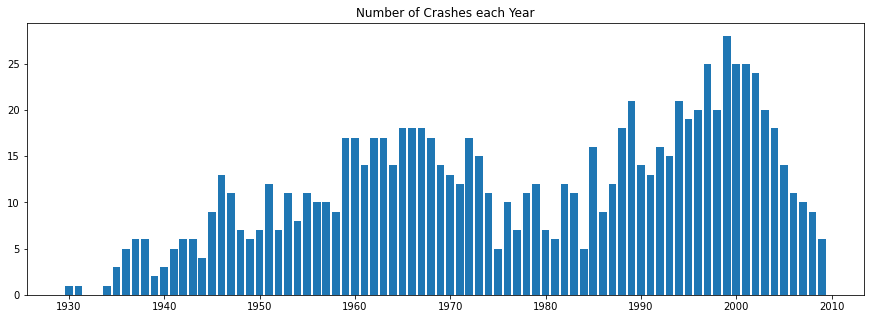

In [10]:
Crshs=pd.DataFrame(airplane.Year.value_counts())

plt.figure(figsize=(15, 5))
plt.bar(x=Crshs.index, height=Crshs["Year"])
plt.title("Number of Crashes each Year")
plt.show()

<AxesSubplot:title={'center':'Top 15 countries by crash locations'}>

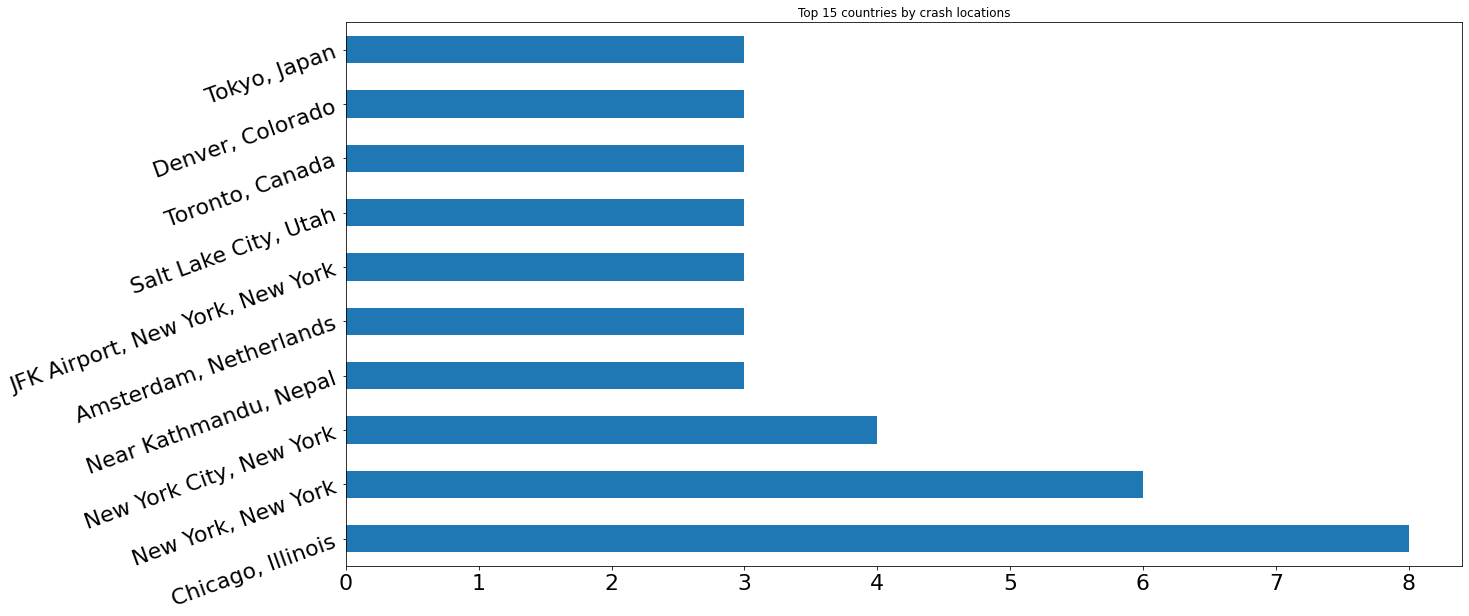

In [11]:
airplane['Location'].value_counts()[:10].plot(kind='barh'
                                        ,  figsize=(20,10), rot=20, fontsize=22, title="Top 15 countries by crash locations")

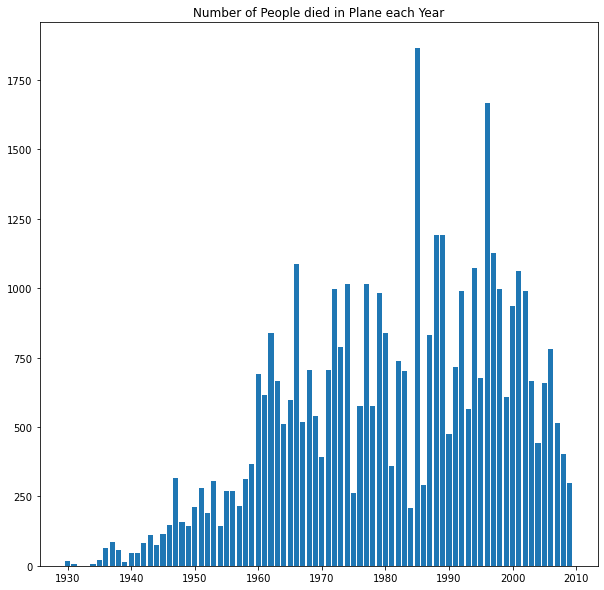

In [12]:
fatals=pd.DataFrame(airplane.Fatalities.groupby(airplane.Year).sum())

plt.figure(figsize=(10, 10))
plt.bar(x=fatals.index, height=fatals["Fatalities"])
plt.title("Number of People died in Plane each Year")
plt.show()

In [13]:
airplane['Survivor']=airplane['Aboard']-airplane['Fatalities']
airplane.head(2)

Date   Time               Location  \
208  01/19/1930  18:23  Oceanside, California   
236  03/31/1931  10:45         Bazaar, Kansas   

                              Operator Flight #  \
208                    Maddux Airlines        7   
236  Trans Continental and Western Air      599   

                                    Route                   Type Registration  \
208   Aqua Caliente, Mexico - Los Angeles  Ford 5-AT-C Tri Motor       NC9689   
236  Kansas City - Wichita -  Los Angeles   Fokker F10A Trimotor       NC-999   

        cn/In  Aboard  Fatalities  Ground  \
208  5-AT-046    16.0        16.0     0.0   
236      1063     8.0         8.0     0.0   

                                               Summary  Year  Survivor  
208  While en route to Los Angeles, the pilot, flyi...  1930       0.0  
236  Shortly after taking off from Kansas City, one...  1931       0.0

In [14]:
FSG_per_year = airplane[['Year', 'Fatalities', 'Survivor', 'Ground']].groupby('Year').sum()
FSG_per_year = FSG_per_year.reset_index()

Text(0, 0.5, 'Count')

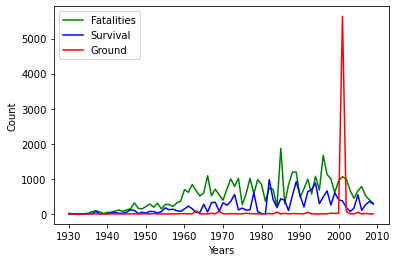

In [115]:
sns.lineplot(x = 'Year', y = 'Fatalities', data = FSG_per_year, color = 'green')
sns.lineplot(x = 'Year', y = 'Survivor', data = FSG_per_year, color = 'blue')
sns.lineplot(x = 'Year', y = 'Ground', data = FSG_per_year, color = 'red')
plt.legend(['Fatalities', 'Survival', 'Ground'])
plt.xlabel('Years')
plt.ylabel('Count')

In [16]:
Locations = airplane.groupby('Location', as_index=False).agg({'Year':'mean'}).sort_values('Year', ascending=False)

In [17]:
fig = px.choropleth(Locations, 
                    locations = 'Location', 
                    locationmode = 'country names', 
                    color = 'Year',
                    hover_data = ['Year'], 
                    title = 'Most Dangerous Locations per years')
fig.show()

In [117]:
SurvivorByPlaneType=pd.DataFrame(airplane.Survivor.groupby(airplane.Type).sum())
SurvivorByPlaneType = SurvivorByPlaneType.sort_values(by='Survivor', ascending=False)
SurvivorByPlaneType.head(5)

Survivor
Type                                  
McDonnell Douglas DC-10-30    871.0   
McDonnell Douglas DC-10-30CF  838.0   
Boeing B-747-122              739.0   
Boeing B-747-121              586.0   
McDonnell Douglas DC-10-10    527.0

<AxesSubplot:title={'center':'Top 5 Airplane Type has number of Survivor'}, ylabel='Type'>

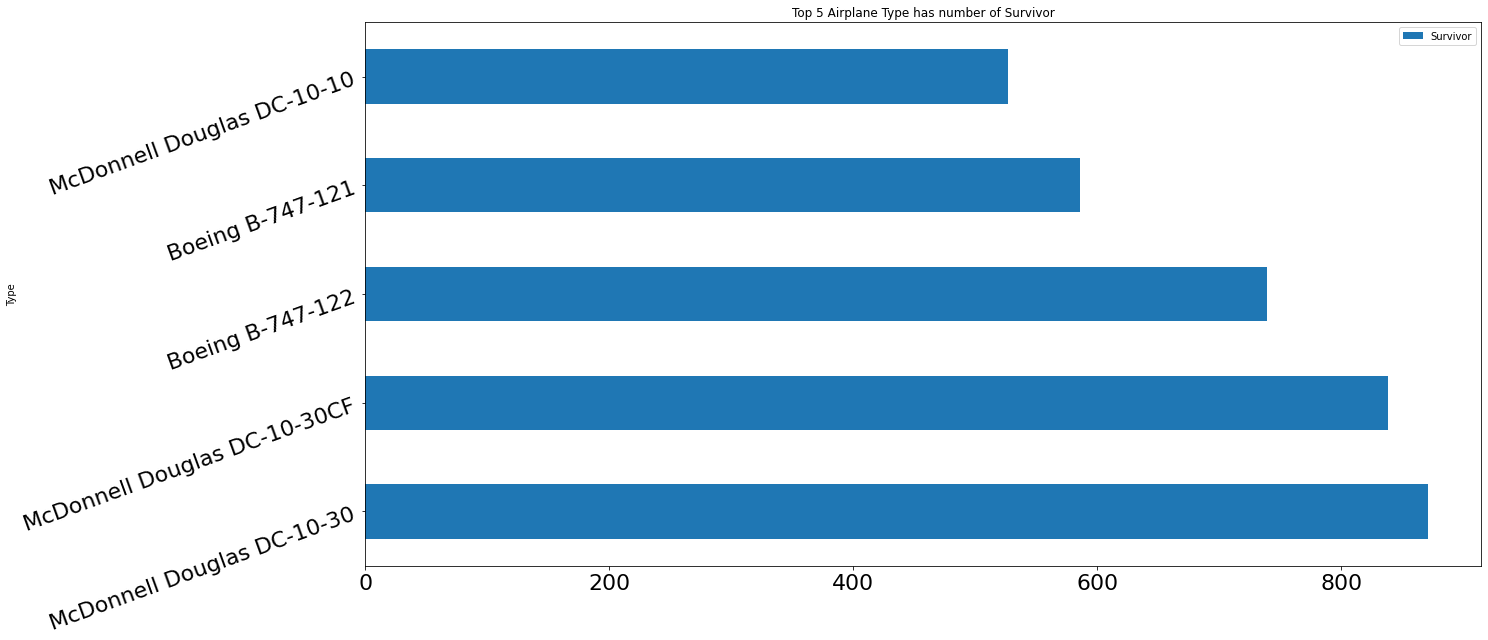

In [122]:
SurvivorByPlaneType[:5].plot(kind='barh'
                                        ,  figsize=(20,10), rot=20, fontsize=22, title="Top 5 Airplane Type has number of Survivor")

In [119]:
CrashesByPlaneType=pd.DataFrame(airplane.Fatalities.groupby(airplane.Type).sum())
CrashesByPlaneType = CrashesByPlaneType.sort_values(by='Fatalities', ascending=False)
CrashesByPlaneType.head(5)

Fatalities
Type                                            
Douglas DC-3                          929.0     
McDonnell Douglas DC-10-10            804.0     
McDonnell Douglas DC-9-32             650.0     
Tupolev TU-154M                       640.0     
Boeing B-747-121 / Boeing B-747-206B  583.0

<AxesSubplot:title={'center':'Top 5 Airplane Type has number of Fatalities'}, ylabel='Type'>

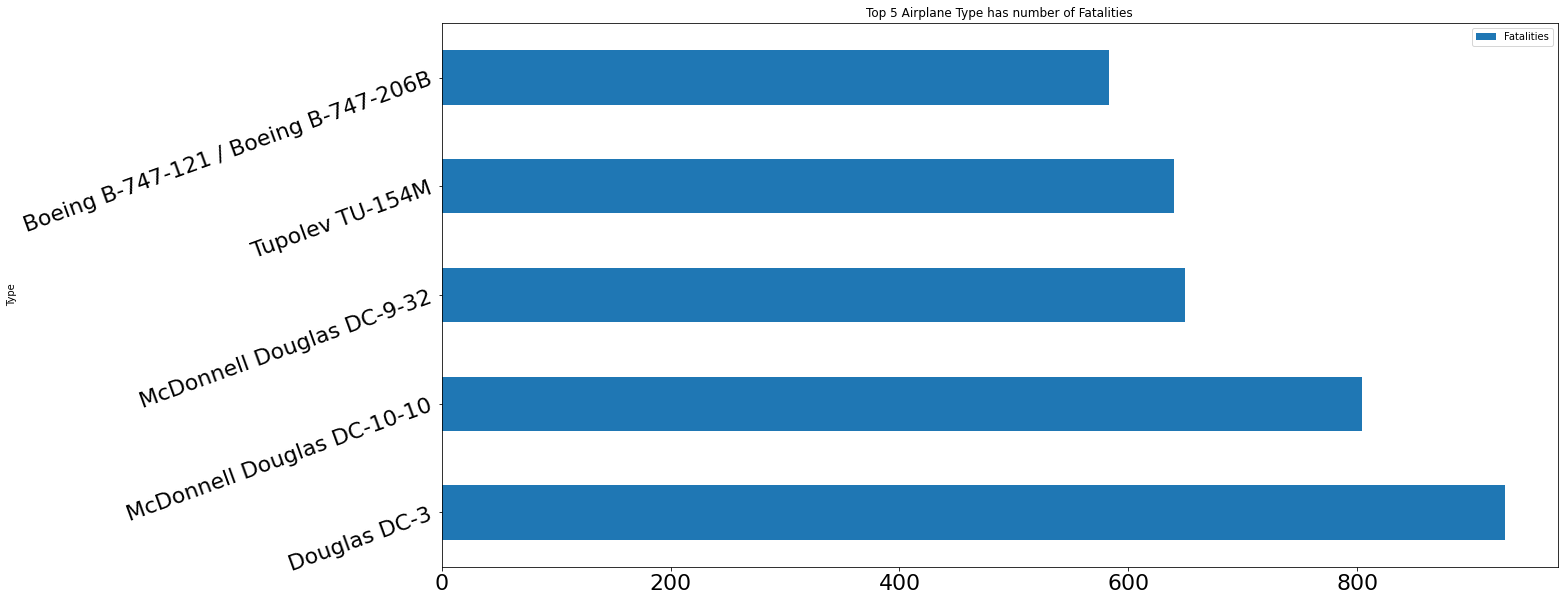

In [121]:
CrashesByPlaneType[:5].plot(kind='barh'
                                        ,  figsize=(20,10), rot=20, fontsize=22, title="Top 5 Airplane Type has number of Fatalities")

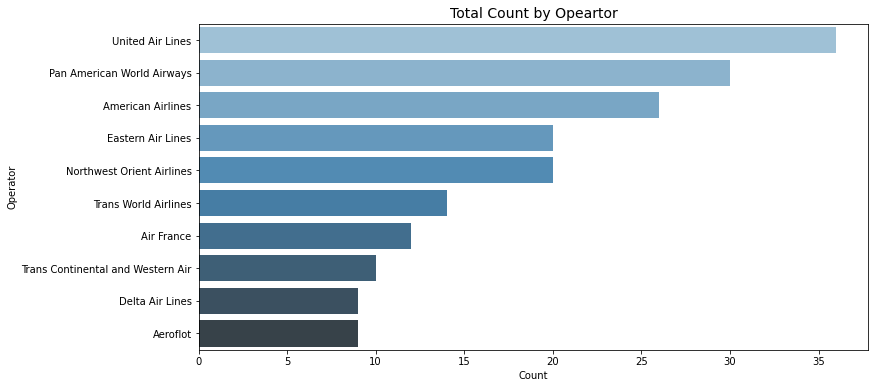

In [20]:
Opreator_total = airplane.groupby('Operator')[['Operator']].count()
Opreator_total = Opreator_total.rename(columns={"Operator": "Count"}) 
Opreator_total = Opreator_total.sort_values(by='Count', ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(y=Opreator_total.index, x="Count", data=Opreator_total,palette="Blues_d",orient='h')
plt.xlabel('Count', fontsize=10)
plt.ylabel('Operator', fontsize=10)
plt.title('Total Count by Opeartor', loc='Center', fontsize=14)
plt.show()

# Data Pre-processing

In [21]:
import re
import string

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text
airplane['Summary_clean'] = airplane['Summary'].apply(clean_text)
airplane.head()

# StopWords

from nltk.corpus import stopwords
data_text = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
data_text = data_text + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in data_text)
    return text
    
airplane['Summary_clean'] = airplane['Summary_clean'].apply(remove_stopwords)
airplane.head(2)

Date   Time               Location  \
208  01/19/1930  18:23  Oceanside, California   
236  03/31/1931  10:45         Bazaar, Kansas   

                              Operator Flight #  \
208                    Maddux Airlines        7   
236  Trans Continental and Western Air      599   

                                    Route                   Type Registration  \
208   Aqua Caliente, Mexico - Los Angeles  Ford 5-AT-C Tri Motor       NC9689   
236  Kansas City - Wichita -  Los Angeles   Fokker F10A Trimotor       NC-999   

        cn/In  Aboard  Fatalities  Ground  \
208  5-AT-046    16.0        16.0     0.0   
236      1063     8.0         8.0     0.0   

                                               Summary  Year  Survivor  \
208  While en route to Los Angeles, the pilot, flyi...  1930       0.0   
236  Shortly after taking off from Kansas City, one...  1931       0.0   

                                         Summary_clean  
208  en route los angeles pilot flying low altitude...  
236  shortly taking kansas city one aircrafts wings...

In [22]:
#Stemmer

import nltk

stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text
airplane['Summary_clean'] = airplane['Summary_clean'].apply(stemm_text)
airplane.head(2)

Date   Time               Location  \
208  01/19/1930  18:23  Oceanside, California   
236  03/31/1931  10:45         Bazaar, Kansas   

                              Operator Flight #  \
208                    Maddux Airlines        7   
236  Trans Continental and Western Air      599   

                                    Route                   Type Registration  \
208   Aqua Caliente, Mexico - Los Angeles  Ford 5-AT-C Tri Motor       NC9689   
236  Kansas City - Wichita -  Los Angeles   Fokker F10A Trimotor       NC-999   

        cn/In  Aboard  Fatalities  Ground  \
208  5-AT-046    16.0        16.0     0.0   
236      1063     8.0         8.0     0.0   

                                               Summary  Year  Survivor  \
208  While en route to Los Angeles, the pilot, flyi...  1930       0.0   
236  Shortly after taking off from Kansas City, one...  1931       0.0   

                                         Summary_clean  
208  en rout los angel pilot fli low altitud due po...  
236  short take kansa citi one aircraft wing separ ...

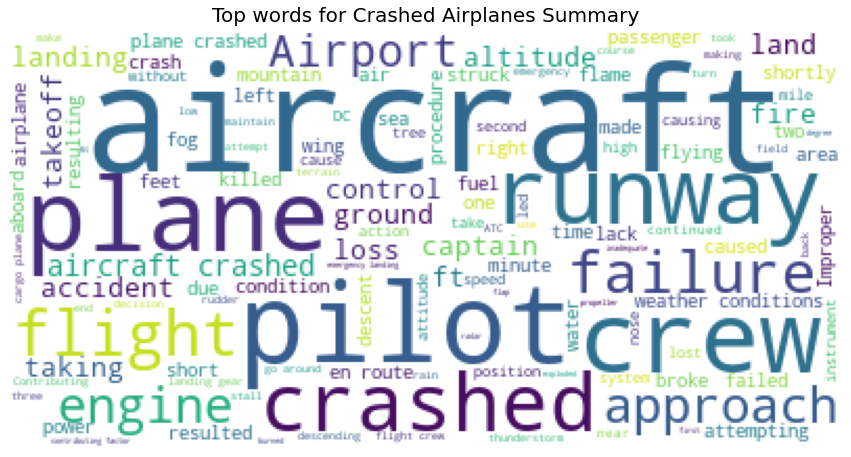

In [23]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wc = WordCloud(
    background_color='white', 
    max_words=200, 
)
wc.generate(' '.join(text for text in airplane['Summary']))
plt.figure(figsize=(15,10))
plt.title('Top words for Crashed Airplanes Summary', 
          fontdict={'size': 20,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

In [24]:
airplane['Summary_clean'].nunique() 

944

# Kmeans Cluster

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [26]:
documents = list(airplane['Summary_clean'])
vectorizer = TfidfVectorizer(stop_words='english') # Stop words are like "a", "the", or "in" which don't have significant meaning
X = vectorizer.fit_transform(documents)

In [27]:
model = MiniBatchKMeans(n_clusters=5, random_state=100)
model.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=100)

In [28]:
model.cluster_centers_

array([[0.        , 0.        , 0.00042574, ..., 0.        , 0.        ,
        0.        ],
       [0.00086522, 0.00038335, 0.00326747, ..., 0.        , 0.        ,
        0.00185974],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00371058, 0.        ,
        0.        ],
       [0.        , 0.        , 0.00138527, ..., 0.        , 0.00418625,
        0.        ]])

In [29]:
model.predict(X)
model.labels_

array([1, 0, 1, 0, 4, 4, 0, 3, 1, 1, 1, 1, 1, 1, 2, 1, 3, 0, 0, 3, 4, 0,
       0, 0, 4, 0, 1, 1, 1, 1, 1, 1, 0, 3, 0, 1, 1, 0, 0, 1, 3, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 3, 3, 0, 1, 1, 1, 1, 1, 4, 3, 3, 4, 1, 1, 1,
       1, 1, 3, 4, 1, 3, 0, 1, 0, 1, 4, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 3, 1, 0, 0, 4, 1, 1, 0, 0, 4, 3, 1, 1, 1, 0, 1, 1, 0, 1, 1, 3,
       1, 1, 1, 1, 4, 1, 1, 4, 1, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 3, 4, 1, 4, 1, 0, 0, 2, 0, 1, 4, 4, 3,
       0, 4, 1, 1, 4, 1, 4, 1, 1, 3, 4, 1, 1, 1, 0, 1, 0, 1, 1, 3, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 3, 0, 4, 4, 1, 4, 2, 1, 1, 2,
       4, 1, 0, 1, 1, 3, 4, 3, 1, 1, 1, 0, 4, 3, 0, 2, 0, 4, 1, 1, 3, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 2, 1, 3, 3, 1, 4, 0, 0, 1, 1,
       1, 3, 1, 0, 1, 0, 0, 1, 0, 3, 0, 1, 3, 3, 1, 1, 0, 1, 0, 0, 3, 3,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 4, 0, 1, 3, 0, 3, 0, 1, 3, 1, 1, 2, 4,
       1, 1, 3, 0, 1, 1, 3, 0, 4, 1, 1, 1, 1, 0, 1,

In [30]:
print ('Most Common Terms per Cluster:')

order_centroids = model.cluster_centers_.argsort()[:,::-1] #sort cluster centers by proximity to centroid
terms = vectorizer.get_feature_names()

for i in range(5):
    print("\n")
    print('Cluster %d:' % i)
    for j in order_centroids[i, :10]: #replace 10 with n words per cluster
        print ('%s' % terms[j]),
    print

Most Common Terms per Cluster:


Cluster 0:
aircraft
plane
crash
hijack
pilot
kill
fuel
collis
caus
passeng


Cluster 1:
approach
runway
aircraft
land
crash
crew
pilot
plane
attempt
airport


Cluster 2:
deton
explos
crash
devic
bomb
plane
aboard
minut
explod
cabin


Cluster 3:
mountain
flight
ft
aircraft
terrain
pilot
crash
navig
error
condit


Cluster 4:
engin
failur
aircraft
takeoff
crash
plane
power
loss
left
lost


In [31]:
pca = PCA(n_components=13, random_state=100)
reduced_features = pca.fit_transform(X.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(model.cluster_centers_)

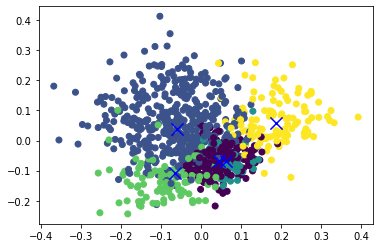

In [32]:
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=model.predict(X))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

# Modeling

In [33]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split

# NMF

In [34]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [35]:
df=airplane[['Summary_clean','Operator','Location']]

In [36]:
pd.set_option('display.max_colwidth',-1)
df.head(2)

<ipython-input-36-80fd2a1a75bd>:1: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



Summary_clean  \
208  en rout los angel pilot fli low altitud due poor weather condit tri turn back left turn left wing struck hill crash burn advers weather condit plane flew sudden squall caus pilot lose control                                                              
236  short take kansa citi one aircraft wing separ flight penetr thunderstorm experienc strong turbul ice plane crash wheat field wingaileron flutter brought moistur leak wing interior weaken glue bond wooden spar notr dame footbal coach knute rockn  kill   

                              Operator               Location  
208  Maddux Airlines                    Oceanside, California  
236  Trans Continental and Western Air  Bazaar, Kansas

In [37]:
X_train, X_test = train_test_split(df, test_size=0.3, random_state=100)

In [38]:
X_train['Operator'].value_counts()

United Air Lines              24
Pan American World Airways    22
American Airlines             20
Eastern Air Lines             14
Northwest Orient Airlines     12
                              ..
Linee Aeree Italiane          1 
Private Charter               1 
British Midland Airways       1 
Midwest Express               1 
PenAir                        1 
Name: Operator, Length: 403, dtype: int64

In [39]:
stemmer = nltk.stem.SnowballStemmer('english')
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
def tokenize(text):
    tokens = [word for word in nltk.word_tokenize(text) if (len(word) > 3 and len(word.strip('Xx/')) > 2 and len(re.sub('\d+', '', word.strip('Xx/'))) > 3) ] 
    tokens = map(str.lower, tokens)
    stems = [stemmer.stem(item) for item in tokens if (item not in stop_words)]
    return stems

In [41]:
# Instatiate
vectorizer = TfidfVectorizer(tokenizer=tokenize, stop_words=None, max_df=0.75, max_features=1000, lowercase=False, ngram_range=(1,2))
# Fit & Transform
tfidf_vectors = vectorizer.fit_transform(X_train['Summary_clean'].values.astype('U')) ## Even astype(str) would work

In [42]:
tfidf_vectors.shape 

(660, 1000)

In [43]:
tfidf_vectors.A

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.20797925, 0.14797658, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [44]:
len(vectorizer.get_feature_names())

1000

In [45]:
clf = decomposition.NMF(n_components=6, random_state=111) # components is the number of topics

W1 = clf.fit_transform(tfidf_vectors)
H1 = clf.components_

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



In [46]:
# NMF Decomposition
tfidf_vectors.shape

(660, 1000)

In [47]:
W1.shape

(660, 6)

In [48]:
W1

array([[0.04035986, 0.00938361, 0.        , 0.02968915, 0.11259834,
        0.        ],
       [0.03451331, 0.00540194, 0.07992885, 0.03291008, 0.0076785 ,
        0.10285106],
       [0.        , 0.00353406, 0.        , 0.27966588, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.00206024, 0.04621156, 0.10915912,
        0.        ],
       [0.06422564, 0.        , 0.03111254, 0.03683098, 0.0399356 ,
        0.06055426],
       [0.        , 0.23512514, 0.        , 0.05664617, 0.03461305,
        0.        ]])

In [49]:
H1.shape

(6, 1000)

In [50]:
H1

array([[0.05415239, 0.        , 0.        , ..., 0.01491799, 0.0049076 ,
        0.00074054],
       [0.        , 0.        , 0.        , ..., 0.00572963, 0.        ,
        0.        ],
       [0.01123587, 0.00756754, 0.        , ..., 0.02443912, 0.        ,
        0.        ],
       [0.        , 0.33971364, 0.08998613, ..., 0.        , 0.03884113,
        0.06803008],
       [0.01772057, 0.        , 0.        , ..., 0.        , 0.01628476,
        0.00124432],
       [0.        , 0.        , 0.        , ..., 0.01079208, 0.01825697,
        0.01909638]])

In [51]:
H1[:, 0:1]

array([[0.05415239],
       [0.        ],
       [0.01123587],
       [0.        ],
       [0.01772057],
       [0.        ]])

In [52]:
num_words=10 # TOPIC IS DEFINED AS A COLLECTION OF 15 WORDS

vocab = np.array(vectorizer.get_feature_names())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]

In [53]:
topics

['approach descent crew altitud aircraft visual instrument short runway descend crash',
 'engin failur engin failur takeoff ditch power fire left left engin right engin',
 'runway land attempt attempt land plane overran runway overran gear land gear pilot',
 'fire plane aboard passeng crash cabin fuel explo kill minut',
 'mountain condit weather pilot weather condit flight terrain poor poor weather plane',
 'control aircraft loss wing loss control turbul sever failur thunderstorm crash']

In [54]:
colnames =["Topic" + str(i) for i in range(clf.n_components)]
docnames = ["Doc" + str(i) for i in range(len(X_train.Summary_clean))]
df_doc_topic = pd.DataFrame(np.round(W1, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_doc_topic.rename(columns = {"Topic0":"Weather","Topic1":"Fire","Topic2":"Bomb","Topic3":"Failur"
                               ,"Topic4":"Mountain","Topic5":"Crash"} ,inplace = False)

Weather  Fire  Bomb  Failur  Mountain  Crash  dominant_topic
Doc0    0.04     0.01  0.00  0.03    0.11      0.00   4             
Doc1    0.03     0.01  0.08  0.03    0.01      0.10   5             
Doc2    0.00     0.00  0.00  0.28    0.00      0.00   3             
Doc3    0.00     0.15  0.00  0.03    0.00      0.00   1             
Doc4    0.15     0.00  0.04  0.01    0.01      0.01   0             
...      ...      ...   ...   ...     ...       ...  ..             
Doc655  0.00     0.00  0.04  0.08    0.11      0.05   4             
Doc656  0.02     0.01  0.23  0.00    0.03      0.03   2             
Doc657  0.00     0.00  0.00  0.05    0.11      0.00   4             
Doc658  0.06     0.00  0.03  0.04    0.04      0.06   0             
Doc659  0.00     0.24  0.00  0.06    0.03      0.00   1             

[660 rows x 7 columns]

In [55]:
X_train.head()

Summary_clean  \
1121  plane crash north slope santa ynez peak  mile northwest santa barbara poor weather failur crew maintain minimum altitud rout flown reason unknown                                                                                                                                                                                       
3529  aircraft crash return airport report sever vibrat attempt land aircraft crash  field bounc slid mobil home ground handler forgot close air start access door crew failur control monitor flight path air speed aircraft detect vibrat                                                                                                   
4773  aircraft explod caught fire  minut schedul takeoff five member cabin crew peopl aboard plane time wit said heard explos flame erupt aboard aircraft ntsb investig report center fuel tank explod follow right tank  minut later caus explos unclear center fuel tank locat near air condit pack generat heat run nonstop prior explos   
833   crash loos power engin due fuel starvat accumul carburetor ice follow loss power engin result fuel starvat reason fuel starvat could determin                                                                                                                                                                                           
938   execut second instrument approach shannon airport aircraft struck ground  feet approach end intend runway broke apart burn continu instrument approach altitud insuffici clear terrain failur fluoresc light may contribut caus plane name clipper empress sky                                                                          

                        Operator                                      Location  
1121  Southwest Airways           Refugio Pass, near Santa Barbara, California  
3529  Galaxy Airlines             Reno, Nevada                                  
4773  Thai Airways                Bangkok, Thailand                             
833   American Airlines           Michigan City, Indiana                        
938   Pan American World Airways  Shannon, Ireland

In [56]:
Wtest = clf.transform(vectorizer.transform(X_test.Summary_clean[:10]))

In [57]:
colnames = ["Topic" + str(i) for i in range(clf.n_components)]
docnames = ["Doc" + str(i) for i in range(len(X_test[:10].Summary_clean))]
df_doc_topic = pd.DataFrame(np.round(Wtest, 3), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_doc_topic.rename(columns = {"Topic0":"Weather","Topic1":"Fire","Topic2":"Bomb","Topic3":"Failur"
                               ,"Topic4":"Mountain","Topic5":"Crash"} ,inplace = False)

Weather   Fire   Bomb  Failur  Mountain  Crash  dominant_topic
Doc0  0.119    0.000  0.145  0.026   0.044     0.000  2             
Doc1  0.037    0.023  0.085  0.000   0.000     0.113  5             
Doc2  0.147    0.000  0.000  0.000   0.023     0.000  0             
Doc3  0.008    0.000  0.007  0.069   0.000     0.113  5             
Doc4  0.000    0.039  0.210  0.000   0.000     0.014  2             
Doc5  0.084    0.249  0.042  0.000   0.000     0.020  1             
Doc6  0.034    0.091  0.000  0.000   0.050     0.111  5             
Doc7  0.052    0.000  0.047  0.000   0.052     0.000  0             
Doc8  0.032    0.010  0.179  0.022   0.000     0.083  2             
Doc9  0.000    0.000  0.000  0.048   0.000     0.216  5

# LDA

In [58]:
vectorizer = TfidfVectorizer(tokenizer=tokenize, stop_words=None, max_df=0.75, max_features=1000, lowercase=False, ngram_range=(1,2))

tf_vectors = vectorizer.fit_transform(X_train['Summary_clean'].values.astype('U'))

In [59]:
lda = decomposition.LatentDirichletAllocation(n_components=3, max_iter=5, learning_method='online', learning_offset=50, n_jobs=-1, random_state=100)

W1 = lda.fit_transform(tf_vectors)
H1 = lda.components_

In [60]:
W1

array([[0.06364324, 0.0638909 , 0.87246586],
       [0.05659668, 0.05635041, 0.88705291],
       [0.05543318, 0.05490896, 0.88965786],
       ...,
       [0.06922984, 0.06926302, 0.86150713],
       [0.06254883, 0.06245183, 0.87499934],
       [0.0790265 , 0.07926918, 0.84170432]])

In [61]:
W1.shape

(660, 3)

In [62]:
num_words=10

vocab = np.array(vectorizer.get_feature_names())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]

In [63]:
len(topics)

3

In [64]:
topics

['shot deton explo devic compart forc explo devic desert deton rout messag',
 'mountain prematur approach crash navig prematur descent aircraft flight error mile',
 'aircraft crash plane land engin pilot approach crew runway failur']

In [65]:
colnames = ["Topic" + str(i) for i in range(lda.n_components)]
docnames = ["Doc" + str(i) for i in range(len(X_train.Summary_clean))]
df_doc_topic = pd.DataFrame(np.round(W1, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_doc_topic.rename(columns = {"Topic0":"Weather","Topic1":"Fire","Topic2":"Crash","Topic3":"Failur"} ,inplace = False)

Weather  Fire  Crash  dominant_topic
Doc0    0.06     0.06  0.87   2             
Doc1    0.06     0.06  0.89   2             
Doc2    0.06     0.05  0.89   2             
Doc3    0.08     0.08  0.83   2             
Doc4    0.06     0.05  0.89   2             
...      ...      ...   ...  ..             
Doc655  0.07     0.07  0.86   2             
Doc656  0.06     0.06  0.89   2             
Doc657  0.07     0.07  0.86   2             
Doc658  0.06     0.06  0.87   2             
Doc659  0.08     0.08  0.84   2             

[660 rows x 4 columns]

In [66]:
X_train.head()

Summary_clean  \
1121  plane crash north slope santa ynez peak  mile northwest santa barbara poor weather failur crew maintain minimum altitud rout flown reason unknown                                                                                                                                                                                       
3529  aircraft crash return airport report sever vibrat attempt land aircraft crash  field bounc slid mobil home ground handler forgot close air start access door crew failur control monitor flight path air speed aircraft detect vibrat                                                                                                   
4773  aircraft explod caught fire  minut schedul takeoff five member cabin crew peopl aboard plane time wit said heard explos flame erupt aboard aircraft ntsb investig report center fuel tank explod follow right tank  minut later caus explos unclear center fuel tank locat near air condit pack generat heat run nonstop prior explos   
833   crash loos power engin due fuel starvat accumul carburetor ice follow loss power engin result fuel starvat reason fuel starvat could determin                                                                                                                                                                                           
938   execut second instrument approach shannon airport aircraft struck ground  feet approach end intend runway broke apart burn continu instrument approach altitud insuffici clear terrain failur fluoresc light may contribut caus plane name clipper empress sky                                                                          

                        Operator                                      Location  
1121  Southwest Airways           Refugio Pass, near Santa Barbara, California  
3529  Galaxy Airlines             Reno, Nevada                                  
4773  Thai Airways                Bangkok, Thailand                             
833   American Airlines           Michigan City, Indiana                        
938   Pan American World Airways  Shannon, Ireland

In [67]:
Wtest = lda.transform(vectorizer.transform(X_test.Summary_clean[:5]))

In [68]:
Wtest.shape

(5, 3)

In [69]:
colnames = ["Topic" + str(i) for i in range(lda.n_components)]
docnames = ["Doc" + str(i) for i in range(len(X_test.Summary_clean[:5]))]
df_doc_topic = pd.DataFrame(np.round(Wtest, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_doc_topic.rename(columns = {"Topic0":"Weather","Topic1":"Fire","Topic2":"Crash","Topic3":"Failur"} ,inplace = False)

Weather  Fire  Crash  dominant_topic
Doc0  0.06     0.06  0.87   2             
Doc1  0.06     0.06  0.88   2             
Doc2  0.09     0.09  0.83   2             
Doc3  0.08     0.08  0.83   2             
Doc4  0.06     0.06  0.88   2

In [70]:
df_doc_topic.shape

(5, 4)

In [74]:
X_test.shape

(284, 3)

In [75]:
X_test.head()

Summary_clean  \
1369  plane crash  mile short runway attempt land crew inattent flight instrument approach pilot sensori illus gave  fals impress aircraft altitud                                                                               
1759  aircraft unusu long takeoff run appear gain altitud difficulti one onehalf mile runway aircraft struck tree crash tidal swamp burst flame  jam right elev spring tab caus crew lose control aircraft                       
1179  plane tree high ground approach flight deviat establish approach procedur                                                                                                                                                  
1318  aircraft broke inflight crash sea en rout rome cairo metal fatigu due design flaw led breakup aircraft third crash caus aircraft nicknam yoke yoke                                                                         
2437  militari charter overran runway takeoff hit il local support structur burst flame lack acceler undetect crew   speed reach caus main land gear wheel remain lock power appli takeoff ici runway due brake hydraulifailur   

                      Operator                  Location  
1369  American Airlines         Springfield, Mississippi  
1759  Caledonian Airways        Douala, Cameroon          
1179  Flying Tiger Line         Issaquah, Washington      
1318  British Overseas Airways  Off Stromboli, Italy      
2437  Capital Airlines          Anchorage, Alaska

# SVD

In [76]:
example=airplane["Summary_clean"]

In [77]:
vectorizer = CountVectorizer(stop_words = 'english')
doc_word = vectorizer.fit_transform(example)
doc_word.shape

(944, 4206)

In [78]:
pd.DataFrame(doc_word.toarray(), index=example, columns=vectorizer.get_feature_names()).head(2)

aaliyah  \
Summary_clean                                                                                                                                                                                                                                                         
en rout los angel pilot fli low altitud due poor weather condit tri turn back left turn left wing struck hill crash burn advers weather condit plane flew sudden squall caus pilot lose control                                                             0         
short take kansa citi one aircraft wing separ flight penetr thunderstorm experienc strong turbul ice plane crash wheat field wingaileron flutter brought moistur leak wing interior weaken glue bond wooden spar notr dame footbal coach knute rockn  kill  0         

                                                                                                                                                                                                                                                            ab  \
Summary_clean                                                                                                                                                                                                                                                    
en rout los angel pilot fli low altitud due poor weather condit tri turn back left turn left wing struck hill crash burn advers weather condit plane flew sudden squall caus pilot lose control                                                             0    
short take kansa citi one aircraft wing separ flight penetr thunderstorm experienc strong turbul ice plane crash wheat field wingaileron flutter brought moistur leak wing interior weaken glue bond wooden spar notr dame footbal coach knute rockn  kill  0    

                                                                                                                                                                                                                                                            abandon  \
Summary_clean                                                                                                                                                                                                                                                         
en rout los angel pilot fli low altitud due poor weather condit tri turn back left turn left wing struck hill crash burn advers weather condit plane flew sudden squall caus pilot lose control                                                             0         
short take kansa citi one aircraft wing separ flight penetr thunderstorm experienc strong turbul ice plane crash wheat field wingaileron flutter brought moistur leak wing interior weaken glue bond wooden spar notr dame footbal coach knute rockn  kill  0         

                                                                                                                                                                                                                                                            abat  \
Summary_clean                                                                                                                                                                                                                                                      
en rout los angel pilot fli low altitud due poor weather condit tri turn back left turn left wing struck hill crash burn advers weather condit plane flew sudden squall caus pilot lose control                                                             0      
short take kansa citi one aircraft wing separ flight penetr thunderstorm experienc strong turbul ice plane crash wheat field wingaileron flutter brought moistur leak wing interior weaken glue bond wooden spar notr dame footbal coach knute rockn  kill  0      

                                                                        

In [79]:
from scipy.linalg import svd
from sklearn.decomposition import TruncatedSVD

lsa = TruncatedSVD(2)
# Fit & Transform
doc_topic = lsa.fit_transform(doc_word)

In [80]:
print (doc_topic)

[[ 2.20070224 -0.50603799]
 [ 1.68560251  0.41637302]
 [ 1.64675533 -1.10420326]
 ...
 [ 2.16239928 -0.79241862]
 [ 0.93418752 -0.69051018]
 [ 3.08185594  0.24044639]]


In [81]:
import numpy as np
pd.DataFrame(np.round((doc_topic),4))

0       1
0    2.2007 -0.5060
1    1.6856  0.4164
2    1.6468 -1.1042
3    3.7075 -1.6738
4    2.0098  1.6215
..      ...     ...
939  2.5517 -1.3488
940  2.0669 -1.6961
941  2.1624 -0.7924
942  0.9342 -0.6905
943  3.0819  0.2404

[944 rows x 2 columns]

In [82]:
print (lsa.explained_variance_ratio_)

[0.03612794 0.02973621]


In [83]:
import numpy as np
np.diag(lsa.explained_variance_ratio_)
pd.DataFrame(np.diag(lsa.explained_variance_ratio_))

0         1
0  0.036128  0.000000
1  0.000000  0.029736

In [84]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2"], 
             columns = vectorizer.get_feature_names())
topic_word

aaliyah     ab  abandon  abat   abba  abbrevi  abejorr   abil  \
component_1  0.0      0.001  0.004    0.0   0.002  0.001    0.0      0.001   
component_2 -0.0     -0.001 -0.005   -0.0  -0.000 -0.000   -0.0     -0.001   

               abl  abnorm  ...   yuri  zaragoza   zero  zerozero  zimbabw  \
component_1  0.008  0.001   ...  0.000  0.000     0.000  0.000     0.0       
component_2  0.002  0.002   ... -0.002 -0.001     0.003  0.001     0.0       

              zone    zue  zulia   zuma  zurich  
component_1  0.002  0.002  0.0    0.000  0.002   
component_2 -0.001  0.002  0.0    0.001 -0.002   

[2 rows x 4206 columns]

In [85]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [86]:
display_topics(lsa, vectorizer.get_feature_names(), 7)


Topic  0
aircraft, crash, plane, crew, land, pilot, approach

Topic  1
engin, aircraft, caus, loss, left, control, takeoff


In [87]:
Vt = pd.DataFrame(doc_topic.round(10),
             index = example,
             columns = ["component_1","component_2" ])
Vt

component_1  \
Summary_clean                                                                                                                                                                                                                                                                                                                                                                                             
en rout los angel pilot fli low altitud due poor weather condit tri turn back left turn left wing struck hill crash burn advers weather condit plane flew sudden squall caus pilot lose control                                                                                                                                                                                             2.200702      
short take kansa citi one aircraft wing separ flight penetr thunderstorm experienc strong turbul ice plane crash wheat field wingaileron flutter brought moistur leak wing interior weaken glue bond wooden spar notr dame footbal coach knute rockn  kill                                                                                                                                  1.685603      
plane crash  mile st joseph heavi fog pilot error take danger weather condit turn close ground fogbound area inaccur weather condit report pilot                                                                                                                                                                                                                                            1.646755      
plane crash en rout albuquerqu kansa citi encount fog poor visibl plane divert kirksvill wit report low fli aircraft made contact ground crash whether plane struck ground pilot attempt make emerg land avail fuel suppli exhaust reason could determin new mexico senat bronson cut  kill improp clearanc airplan albuquerqu compani ground personnel plane twoway radio function proper  3.707502      
crash  mile south gilmer outboard engin separ aircraft propel blade broke result imbalanc condit led loss control aircraft                                                                                                                                                                                                                                                                  2.009781      
...                                                                                                                                                                                                                                                                                                                                                                                              ...      
commut plane crash attemptiong land rain sleet  mile northeast buffalo niagara intern airport schedul land preliminari evid suggest crew select land gear set flap  degre immedi select flap stick shaker activ captain pull control slow airplan even caus plane stall                                                                                                                     2.551674      
plane final approach runway  crash  mile short runway field broke three nine peopl kill  injur preliminari indic show fals read faulti altimet caus autopilot sharpli slow jet land short runway                                                                                                                                                                                            2.066859      
cargo plane crash burst flame land narita airport wind    mph plane bounc twice runway veer left turn side burst flame fire destroy aircraft                                                                                                                                                                                                                                                2.162399      
passeng plane crash poor weather mo